<a href="https://githubtocolab.com/lucashervier/aibt/blob/main/6_intro_to_deeplearning/Introduction_to_deep_learning_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

**All Rights Reserved**

**Copyright (c) 2021 IRT Saint-Exupery**

*Lab 2 contact : mehdi.zouitine@irt-saintexupery.com*

# Labs 5: Introduction to Deep Learning

<div class="alert alert-block alert-info">
<b> Scope of this class: </b>
5th hands'on practice of the AIBT mastere. In this session we will study and implement classical deep learning pipeline in Pytorch
</div>

The first part is inspired by an implementation of my colleague David bertoin from IRT Saint-Exupéry.


In [33]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## 0. Introduction


The general concepts that you learned in machine learning models remain the same for deep learning.

Just like in classical machine learning, the goal of a deep learning model is to learn a parameterized function $f_{\theta}$ to solve a task. 
More precisely this set of parameters $\theta$ is learned by minimizing an error function $L$ on a dataset $\mathcal{D}$.

Deep learning differs from classical machine learning because it does not require feature engineering.
It is the network that will learn to extract the features useful to solve the task.

In this session we will restrict ourselves to **supervised learning** tasks. : 
The data set is therefore of the following form $\mathcal{D}:= (X,Y)$.

And we try to minimize the following criteria:
* For classfication task : 
$L(\theta)=-\mathbb{E}_{(X, Y) \sim P}\left(\log \left(f_{\theta}(Y / X)\right)\right.$
* For regression task : $L(\theta)=\mathbb{E}_{(X, Y) \sim P}\left(\|Y-f_\theta(X)\|^{2}\right)$




## 1. Components of a deep learning pipeline

A supervised deep learning pipeline generally contains the following elements: 
* A **labelled dataset** $(X,Y)$
* A **dataloader** (which allows to sample **batches** of data from the dataset)
* A **neural network** $f_{\theta}$
* A **loss function** $L$
* An **optimizer** that will allow the updating of the weights $\theta$ by gradient descent on the loss function $L$

##2. Data and data Loading

In [34]:
from sklearn.datasets import load_boston
df = load_boston();

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

## 2. Neural network from scratch : Multilayer Perceptron 

To introduce neural networks we will work with the famous Boston dataset : The objective is to predict the **value of prices** of the house using the given **features**.

In [35]:
data = np.asarray(df.data, dtype='float32')
target = np.asarray(df.target, dtype='float32')

<div class="alert alert-block alert-info">
    
<b> Exercise 2.0 : </b>

Separate your data into a training set and a validation set using `train_test_split`.


</div>



<div class="alert alert-block alert-info">
    
<b> Exercise 2.1 : </b>

Normalize the data and the target using `StandardScaler`.


</div>

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, target, test_size = 0.2, random_state=42)


from sklearn import preprocessing
# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
y_train = scaler.fit_transform(y_train.reshape(-1,1))
y_val = scaler.transform(y_val.reshape(-1,1))

Neural networks are composed of layers.
A layer is composed of two methods : 
* The **forward** method allows to apply the layer function to the inputs.
* The **backward** method allows to compute the gradient of the weights of the layer compared to the gradient of the next layer.

In [37]:
import abc
class Layer(abc.ABC):
    def __init__(self):
        self.layer_type = 'abstract'

    def forward(self, inputs):
        raise NotImplementedError
    
    def backward(self, grad):
        raise NotImplementedError

A linear layer is composed with a weights matrice $W$ and a bias vector $b$.
The result of the application of the layer on $x$ is given by :  $$L_{W}(x) = Wx+b$$

When the layer is created, the weights W and b are randomly initialized.



<div class="alert alert-block alert-info">
    
<b> Exercise 2.2 : </b>
Implement the `Linear` layer object.

**Tip 1**: To apply the operation use the function `np.matmul function`.

**Tip 2**: Initialize the weights between $[−0.1,0.1]$ by using the function `np.random.uniform`


</div>


In [38]:
X_train

array([[ 1.2877018 , -0.50032014,  1.0332369 , ...,  0.84534293,
        -0.07433674,  1.753505  ],
       [-0.33638445, -0.50032014, -0.4131595 , ...,  1.2047412 ,
         0.43018377, -0.56147414],
       [-0.40325332,  1.0132713 , -0.71521825, ..., -0.6371765 ,
         0.06529749, -0.6515951 ],
       ...,
       [-0.40547013,  2.9593177 , -1.3033614 , ..., -0.59225154,
         0.3790101 , -0.9106925 ],
       [ 0.85189736, -0.50032014,  1.0332369 , ...,  0.84534293,
        -2.694586  ,  1.5225704 ],
       [-0.38135594, -0.50032014, -0.35216686, ...,  1.1598163 ,
        -3.1215806 , -0.25731632]], dtype=float32)

In [39]:
404*13

5252

In [40]:
class Linear(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        #weights is a tensor of dimension: (input_size x output_size) initialized...
        #biais is a tensor of dimension: (output_size)
        self.layer_type = 'linear'
        self.params ={}
        self.grads = {}
        self.params["weights"] = np.random.uniform(-0.1,0.1, size = (input_size,output_size))
        self.params["bias"] = np.random.uniform(-0.1,0.1, size = (output_size))

    def forward(self, inputs):
        # outputs = inputs @ weights + biais
        #we will store the inputs they will be used in the backward method
        self.inputs = inputs
        outputs = np.matmul(inputs, self.params["weights"]) + self.params["bias"]
        return outputs
    
    def backward(self, grad):
        # we need so sum gradients over the batch axis
        self.grads["weights"] = np.matmul(self.inputs.T, grad)
        self.grads["bias"] = np.sum(grad, axis=0)
        return np.matmul(grad, self.params["weights"].T)


<div class="alert alert-block alert-info">
    
<b> Test : </b>
Make sure your implementation passes the test.
</div>

In [41]:
input_size, output_size = 10, 5
X = np.random.rand(input_size)
grads = np.random.rand(10,5)
test_linear_layer = Linear(input_size, output_size)
assert test_linear_layer.forward(X).shape == (5,)
assert test_linear_layer.backward(grads).shape == (10, 10)


Activation functions are a very important element in deep learning architectures. These functions allow the introduction of non-linearity.

An activation function is a differentiable function, the most famous is called `Relu` : $$Relu :\mathbb{R}^d \rightarrow \mathbb{R}^d$$  $$Relu(x) = max(0,x)$$

<div class="alert alert-block alert-info">
    
<b> Exercise 2.3 : </b>
Implement the relu activation function and it's derivative.

**Tip**: Use `np.max` and `np.where`.



</div>

In [42]:
def relu(x):
    return np.maximum(0,x)

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

From a computer point of view, an activation can be seen as a layer.


<div class="alert alert-block alert-info">
    
<b> Exercise 2.4 : </b>
Implement the `Activation``
 object.

**Tip / Reminder**: if $y=f(x)$ and $x=f(z)$ then $\frac{\partial y}{\partial z} = f'(x) * g'(z)$



</div>

In [43]:
class Activation(Layer):
    def __init__(self, f, f_prime):
        super().__init__()
        self.layer_type = 'activation'
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs):
        self.inputs = inputs
        return self.f(inputs)
    
    def backward(self, grad):
        """ if y = f(x) and x = g(z)
        then dy/dz = f'(x) * g'(z)
        In our case g'(z) correspond to the incomming gradients
        """
        return self.f_prime(self.inputs) * grad


A neural network $f$ Is a succession of layers and activations : $$\left.f(x)=f_{N}\left(f_{N-1}\left(\ldots f_{1}\left(x ; W_{1}, b_{1}\right) ; W_{2}, b_{2}\right) ; \ldots\right) ; W_{N}, b_{N}\right)$$



<div class="alert alert-block alert-info">
    
<b> Exercise 2.5 : </b>
Implement the `Neuralnetwork` object.

**Tip / Reminder**: The list operator `reversed` must be used.



</div>

In [44]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
      self.inputs = inputs
      for layer in self.layers:
        inputs = layer.forward(inputs)
      return inputs

    def backward(self, grad):
      for layer in reversed(self.layers):
        grad  = layer.backward(grad)
      return grad

<div class="alert alert-block alert-info">
    
<b> Exercise 2.6 : </b>
Implement a function `create_neural_net`.

It must create a neural network consisting of 3 layers:
* an input layer receiving a vector of dimension 13 and consisting of 40 neurons
* a hidden layer of 40 neurons
* an output layer consisting of a single neuron




</div>

In [45]:
def create_neural_net():
  layers = [Linear(13,40), Activation(relu, relu_prime), Linear(40,1)]
  net = NeuralNetwork(layers)
  return net
  

<div class="alert alert-block alert-info">
    
<b> Exercise 2.7 : </b>
* Instantiate a neural network
* Make a precition on `X_val` using this neural network.
* Compute the error using the MSE metric.
* Plot the ground truth and the prediction

**Tip**: Use `inverse_transform` and `mean_absolute_error` functions from sklearn.

</div>

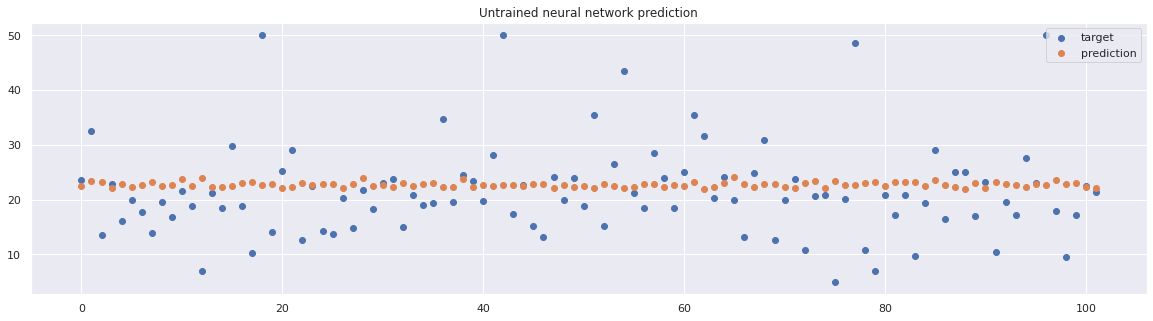

In [46]:
from sklearn.metrics import mean_absolute_error
net = create_neural_net()
y_pred = net.forward(X_val)
mse = mean_absolute_error(y_pred,y_val)

   
plt.figure(figsize=(20,5))
plt.scatter(range(len(y_val)), scaler.inverse_transform(y_val), label='target')
plt.scatter(range(len(y_val)), scaler.inverse_transform(y_pred), label='prediction')
plt.title("Untrained neural network prediction")
plt.legend()

<div class="alert alert-block alert-info">
    
<b> Exercise 2.8 : </b>
Comment the results : 
* Why is the model error so large ?
* Why do all the predictions line up ?
</div>

In order to train the network, we need a loss function to minimize.
In the regression set up, the MSE do perfectly the job ! 
$$MSE(f(x),y) = \sum_{i}^{n}\frac{(f(x_i) - y_i)^2}{n}$$ 

<div class="alert alert-block alert-info">
    
<b> Exercise 2.9 : </b>
Implement the `MSE` function and its gradient.
</div>

In [47]:
class MSE():

    def loss(self, y_pred, y_true):
        #returns a scalar
        return np.mean((y_pred - y_true)**2)
    
    def grad(self, y_pred, y_true):
        #returns a tensor of gradients
        return 2*(y_pred - y_true)


The loss function provides you with the error of your model. This error then allows you to update the weights of your model by gradient descent. The update of the weights is done with an optimizer. 
The optimizer goes through the weights and applies a gradient descent on these weights.

<div class="alert alert-block alert-info">
    
<b> Exercise 2.10 : </b>
Implement an optimizer.*texte en italique*
</div>

In [48]:
class SGD():
    def __init__(self, lr=0.001):
        self.lr = lr
    
    def step(self, net):
        for layer in net.layers:
            if layer.layer_type == 'linear':
                for param, grad in zip(layer.params.values(), layer.grads.values()):
                    param -= self.lr * grad


<div class="alert alert-block alert-info">
    
<b> Exercise 2.11 : </b>
Implement the fit function.
This function must:

* compute the predictions of the network on the learning batch
* compute the loss
* compute the gradient of the loss
* retropagate the gradients
* perform an optimization step
* return the loss
</div>


In [49]:
def fit(net, loss, optimizer, X, y):
    y_pred = net.forward(X)
    prediction_loss = loss.loss(y_pred,y)
    gradients = loss.grad(y_pred,y)
    net.backward(gradients)
    optimizer.step(net)    
    return prediction_loss

<div class="alert alert-block alert-info">
    
<b> Exercise 2.12 : </b>
Train your neural network.
</div>

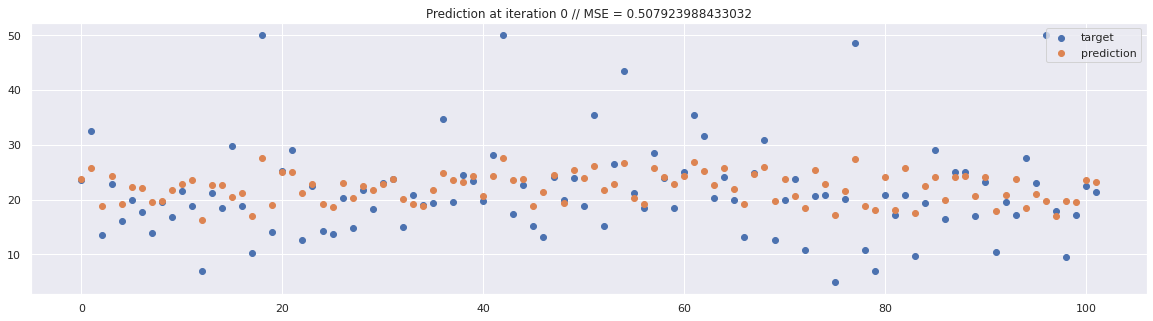

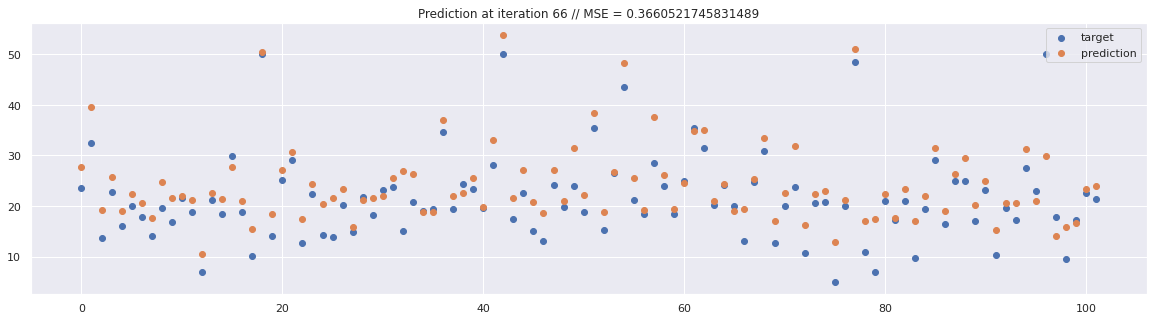

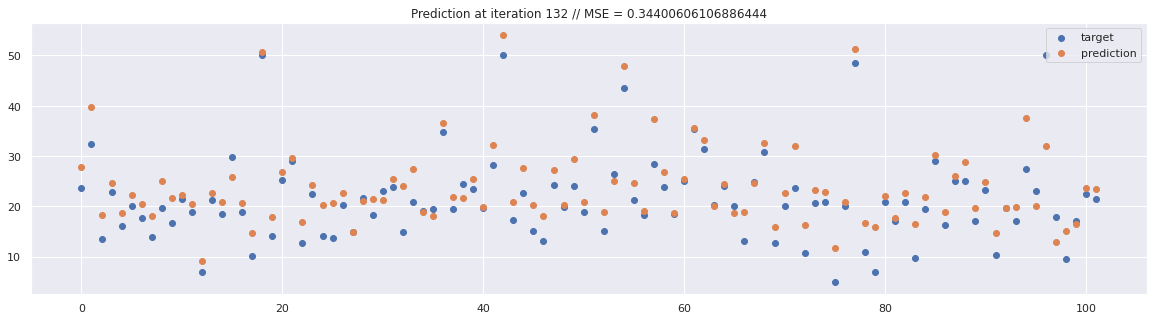

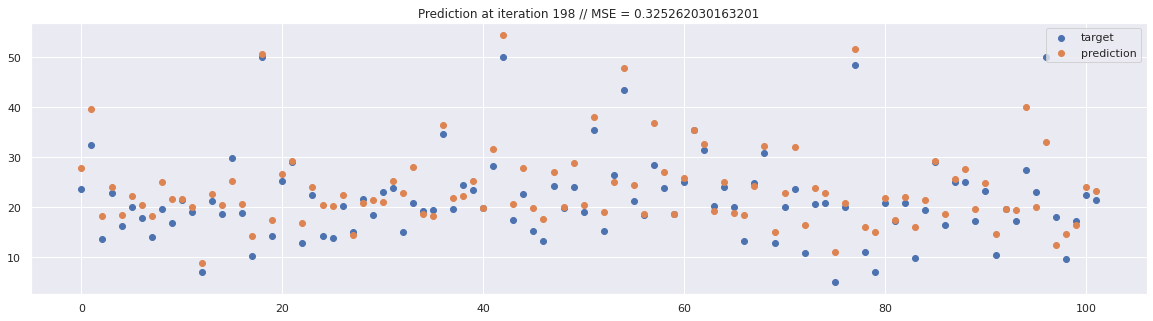

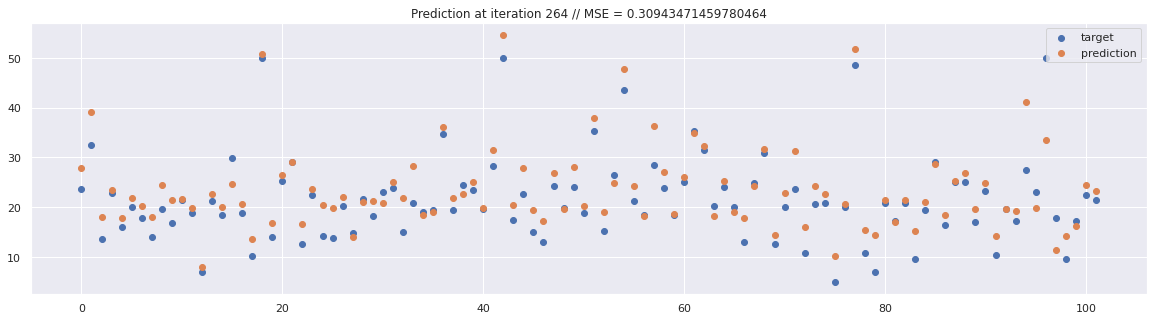

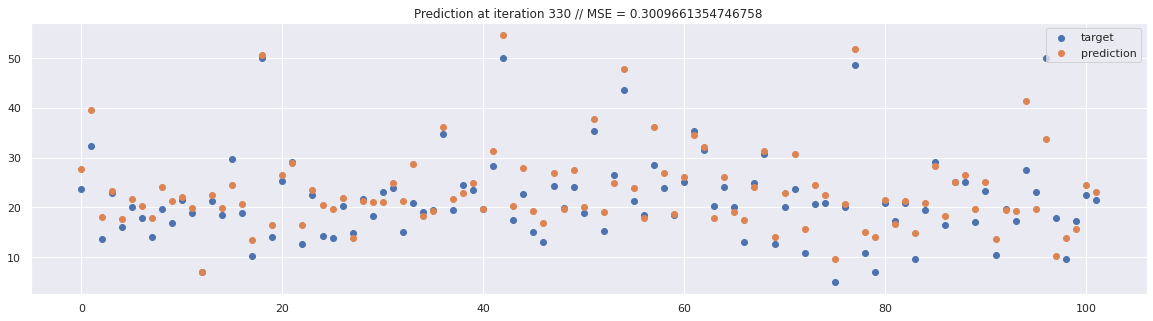

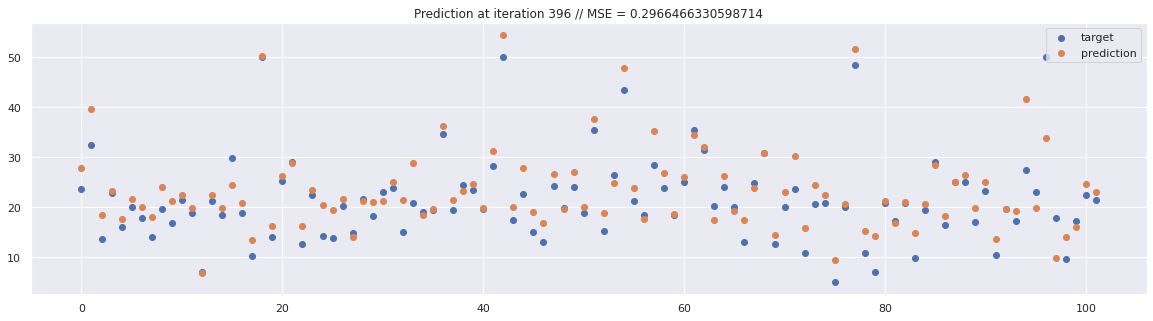

0.28159541786506315


In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

net = create_neural_net()
optimizer = SGD(lr=0.001)
loss = MSE()
k=0
for i, (x, y) in enumerate(zip(X_train, y_train)):
    training_loss = fit(net,loss,optimizer,X_train,y_train)
    y_pred = net.forward(X_val)
    if i%66 == 0:
      fig = plt.figure(figsize=(20,5));
      plt.scatter(range(len(y_val)), scaler.inverse_transform(y_val), label='target');
      plt.scatter(range(len(y_val)), scaler.inverse_transform(y_pred), label='prediction');
      plt.title(f"Prediction at iteration {i} // MSE = {mean_absolute_error(y_pred, y_val)}")
      plt.legend()
      plt.show()
print(mean_absolute_error(y_pred, y_val))

<div class="alert alert-block alert-info">
    
<b> Exercise 2.13 : </b>
Train your neural network over 10 epochs.
</div>

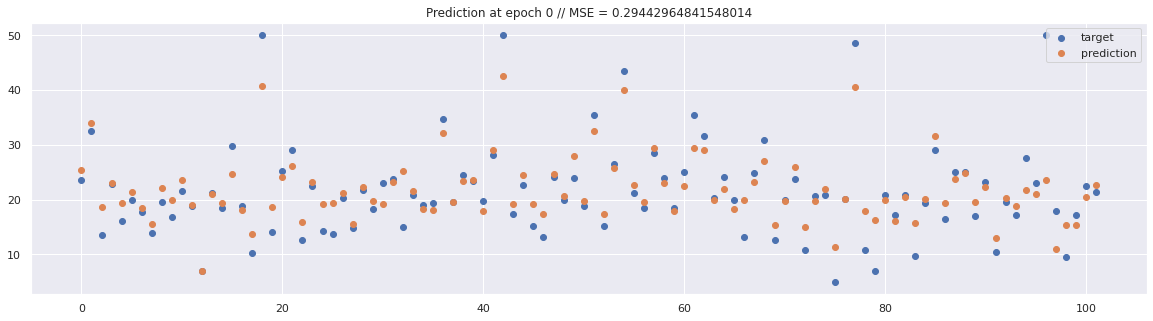

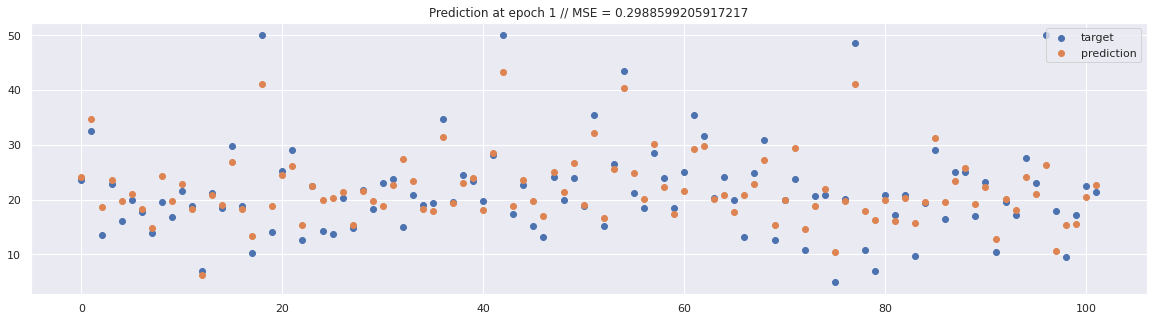

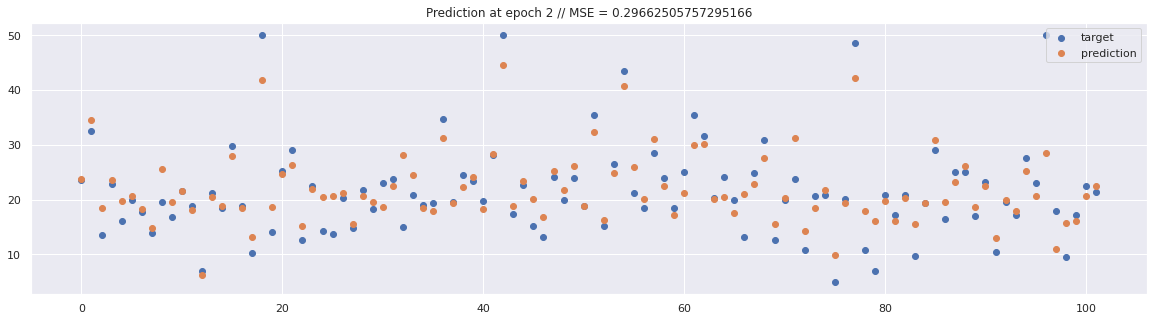

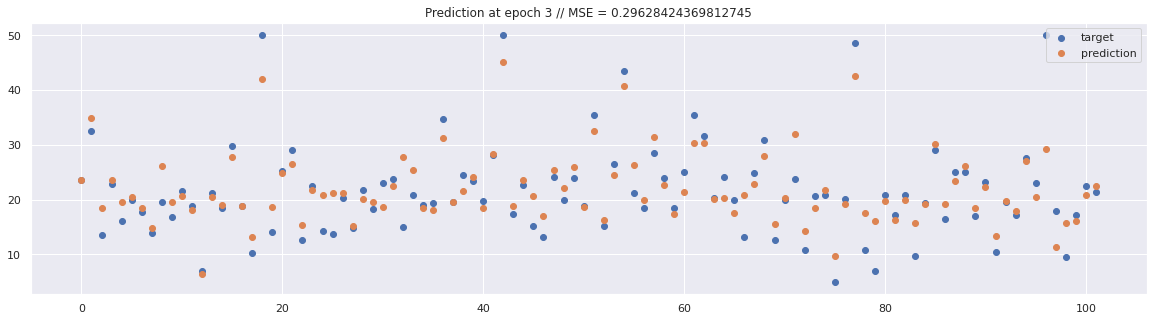

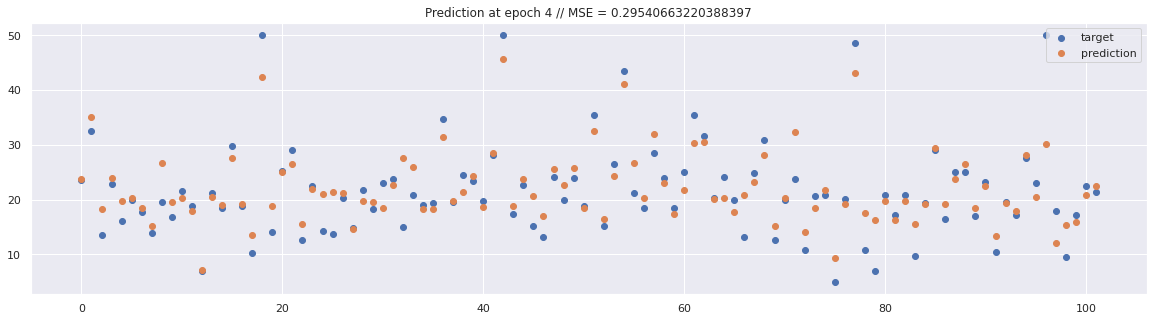

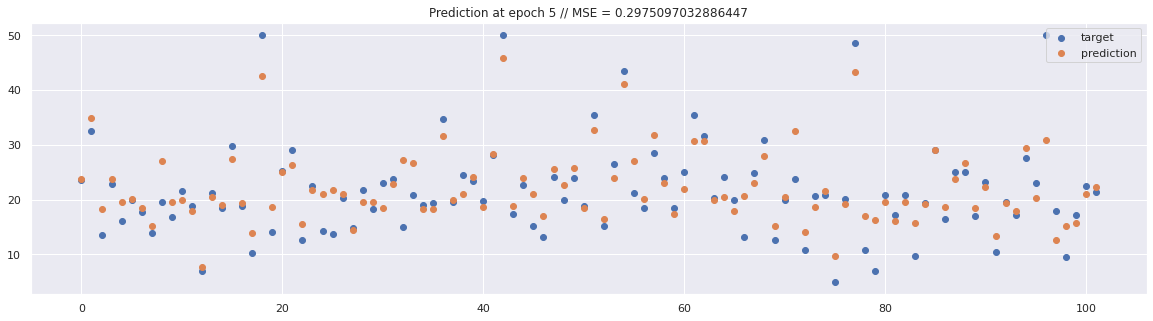

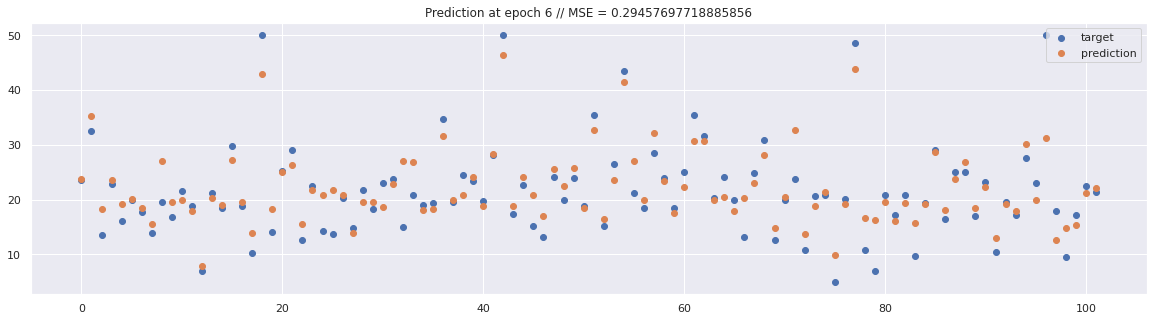

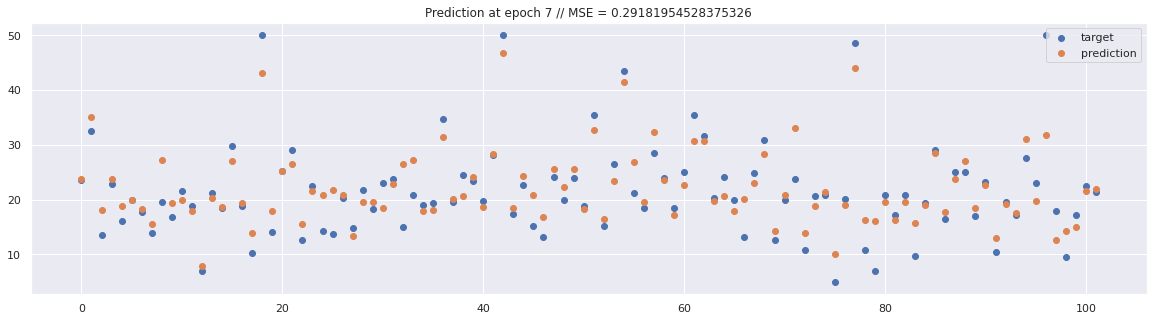

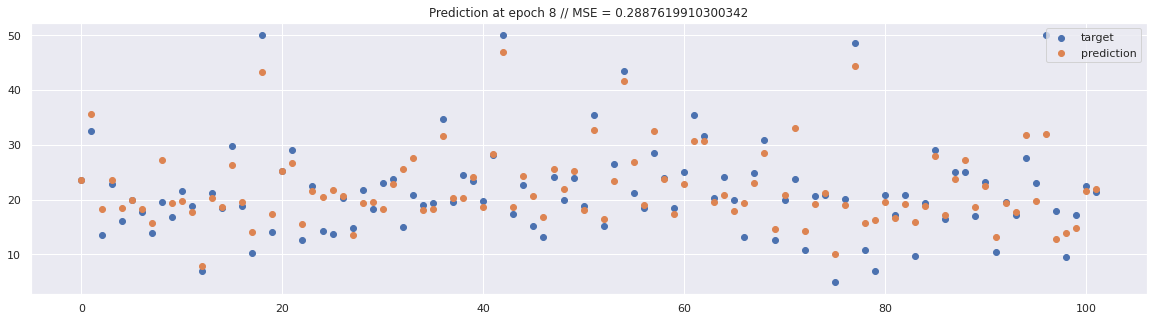

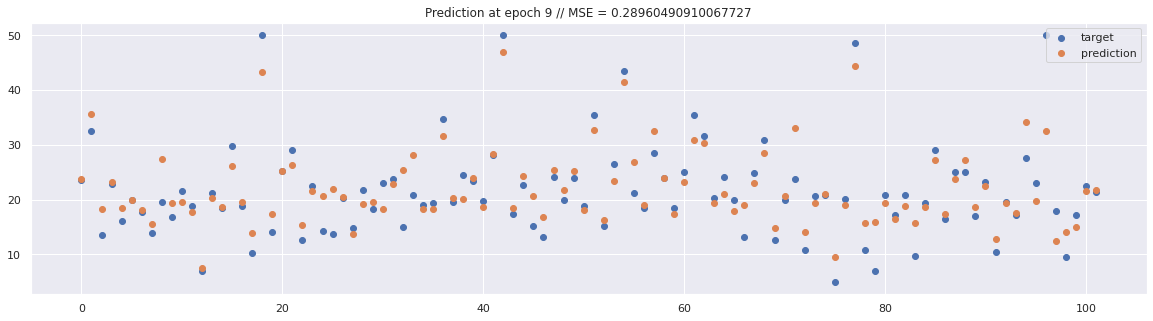

In [51]:
net = create_neural_net()
optimizer = SGD(lr=0.01)
loss = MSE()
for epoch in range(10):
  for i, (x, y) in enumerate(zip(X_train, y_train)):
      training_loss = fit(net, loss, optimizer, np.array([x]), np.array([y]))
      y_pred = net.forward(X_val)
  fig = plt.figure(figsize=(20,5));
  plt.scatter(range(len(y_val)), scaler.inverse_transform(y_val), label='target');
  plt.scatter(range(len(y_val)), scaler.inverse_transform(y_pred), label='prediction');
  plt.title(f"Prediction at epoch {epoch} // MSE = {mean_absolute_error(y_pred, y_val)}")
  plt.legend()
  plt.show()



##3. Deep learning framework : Pytorch

Pytorch is a deep learning framework allowing to automate many operations.
It also provides a lot of tools to create and train deep learning models.

In deep learning, the type of data used is the **Tensor**.
A tensor is an array of data that can contain vectors,images and much more ! 


You can instantiate a tensor using the `torch.tensor` method.



<div class="alert alert-block alert-info">
    
<b> Exercise 3.0: </b>
* Create a tensor `age_1` containing your age with type `long` and a tensor `size_1` containing your height in cm with type `float32`.
</div>

In [52]:
age_1 = torch.tensor([27], dtype=torch.long)
size = torch.tensor([173], dtype=torch.float32)

<div class="alert alert-block alert-info">
    
<b> Exercise 3.1: </b>  
Imagine your task is to predict the life expectancy of a person $y_i$ from a set of bioligical measure $(x_i^0,x_i^1,x_i^2,\ldots,x_i^6)$.
* Create three tensors `x_1`, `x_2` and `x_3` of biological data and form a data batch of size 3 `batch_x` with these three tensors.

**Tip**: Use `torch.stack`.
</div>


In [53]:
x1 = torch.tensor([1,2,3,4,5])
x2 = torch.tensor([6,7,8,9,10])
x3 = torch.tensor([7,10,9,8,11])

batch_x = torch.stack([x1,x2,x3], dim=0)

You can also check some attributes of your tensor.
For example you can look at the shape of the tensor using the `shape` attribute, the gradient of a tensor using the `grad` attribute and the type using `dtype`.

You can also see under which device your tensor is with the attribute `device`.
Finally you can also put your data on gpu using the `torch.tensor.to` method.
The possible devices are "cpu" and "cuda".

In [ ]:
print(x1.device)
x1 = x1.to('cpu')
print(x1.device)

<div class="alert alert-block alert-info">
    
<b> Exercise 3.2: </b>  
* Look at the device, gradient, type and shape of your tensors.
* Change the device of your tensors to "cuda".
</div>

In [ ]:
#  j'ai fait cela dans la cellule qui précède

<div class="alert alert-block alert-info">
    
<b> Exercise 3.3: </b>  

Transform the first three samples of `X_train` into a tensor and make a batch that you convert to the `torch.float32` type and pass to the cuda device.
</div>

In [ ]:
X_train[0:3,]

In [ ]:
len(X_train)

In [ ]:
X_train_batch = torch.from_numpy(X_train[0:200,])
print(X_train_batch)
print(X_train_batch.device)
X_train_batch = X_train_batch.to('cuda')
print(X_train_batch.device)

In [ ]:
len(X_train_batch)

To manage more easily the processing of your data, pytorch proposes a tool: the `Dataset` class.

This class allows the creation of a data generator which will be very useful when training your model.

This dataset allows to retrieve the data as a tensor.
The dataset implements 2 methods : The `__get_item__` method which allows to access to a sample and the `__len__` method which returns the number of sample.

<div class="alert alert-block alert-info">
    
<b> Exercise 3.4: </b>  
Implement a torch dataset allowing you to access the boston dataset.
* The `__get_item__` method should return a dict containing the data and labels in tensor form.
* The `__len__` method should return the number of samples.

</div>

In [24]:
from torch.utils.data import Dataset

In [25]:
class TabularDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y
  def __getitem__(self,idx): 
    return {"data": torch.from_numpy(self.X[idx]),"label": torch.from_numpy(self.y[idx])}

  def __len__(self):
    return len(self.X)


<div class="alert alert-block alert-info">
    
<b> Exercise 3.5: </b>  
Set up a dataset for the train set and one for the validation set

</div>

In [26]:
train_dataset = TabularDataset(X_train,y_train)
val_dataset = TabularDataset(X_val,y_val)

In [27]:
print(f"First sample (x,y) of the dataset : {train_dataset[0]} \n") # get_item method
print(f"There are {len(train_dataset)} samples in the dataset.") # len method

First sample (x,y) of the dataset : {'data': tensor([ 1.2877, -0.5003,  1.0332, -0.2781,  0.4893, -1.4281,  1.0280, -0.8022,
         1.7069,  1.5784,  0.8453, -0.0743,  1.7535]), 'label': tensor([-1.1584])} 

There are 404 samples in the dataset.


Once the dataset is created, another class is used to wrap this dataset: The `Dataloader`.
A dataloader allows to sample batches of dataset data and to parallelize the batch formation on several workers.

<div class="alert alert-block alert-info">
    
<b> Exercise 3.6: </b>  
Create a train dataloader and a validation dataloader that returns sample batches of size 16.

</div>

In [28]:
from torch.utils.data import DataLoader

In [29]:
batch_size = 16
num_workers = 2
train_dataloader = DataLoader(train_dataset, batch_size, num_workers)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers)

<div class="alert alert-block alert-info">
    
<b> Exercise 3.7: </b>  
* Inspect the first batch of your training loader.
* Create a data variable and a label variable containing respectively, the data and the labels of the first batch

**Tip**: To get the first element of the loader use: `next(iter(loader))`
</div>

In [30]:
first_batch = next(iter(train_dataloader))
data = first_batch["data"]
label = first_batch["label"]

In [ ]:
data.shape([1])

In the previous part you created a neural network with linear layers.
You had to implement the forward and backward method for each layer.
Pytorch allows you to use well known layers like linear or convolutional layers.


<div class="alert alert-block alert-info">
    
<b> Exercise 3.8: </b>  
Implement a neural network with a single linear layer using the pytorch framework.

**Tip**: Use `nn.Linear` layer.
</div>

In [32]:
import torch.nn as nn
class MLPRegression(nn.Module): # All pytorch models must inherit the nn.Module
  def __init__(self,in_features):
     super(MLPRegression, self).__init__() # The constructor of the class calls the constructor of its parent class with the keyword "super".
     self.layer1 = nn.Linear(in_features,1)
  def forward(self,x):
    value = self.layer1(x)
    return value


<div class="alert alert-block alert-info">
    
<b> Exercise 3.9: </b>  
Use your neural network to make a prediction on the first batch of data.
</div>

In [ ]:
in_features = data.shape[]
mlp_regression = MLPRegression()

In [ ]:
preds = mlp_regression.forward(data)

::Now we will move on to the most important part of the session: Training the model.
Writing a **training loop** is not a simple thing at first.
The following code implements a generic training loop that I advise you to keep for your future work in deep learning.

<div class="alert alert-block alert-info">
    
<b> Exercise 3.10: </b>  
* Explain the role of each argument of the function
* Fill in the blank code
* Comment on each line of the training loop (except the lines used for visualization).
* Raise your hand to give me an oral report on this question 
</div>

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
sns.set()
def train_regressor(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    nb_epoch: int,
    criterion: nn.Module,
    batch_size:int=16,
    device: torch.device = torch.device("cuda:0"),
    
    verbose: bool=True,
) -> None:
    """
    Pytorch training loop
    Args:
        model (nn.Module): Pytorch classification model
        optimizer (torch.optim.Optimizer): Optimizer for the model
        train_loader (DataLoader): DataLoader for training fold
        valid_loader (DataLoader): DataLoader for validation fold
        nb_epoch (int): Number of epoch
        criterion (nn.Module): Loss
        device (torch.device): .Defaults to `torch.device("cuda:0")`
        verbose (bool): Verbose term
    """
    loaders = {"train": train_loader, "validation": valid_loader}
    model.to(device)
    train_loss = []
    val_loss = []
    for epoch in range(1, nb_epoch + 1):
        if verbose:
          print("-" * 80)
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for sample in loaders[phase]:
                data = ...
                label = ...
                optimizer.zero_grad()
                data, label = data.to(device), label.to(device)
                with torch.set_grad_enabled(phase == "train"):
                    output = ...
                    pred_label = ...
                    loss = ...
                    if phase == "train":
                        ... # Compute the gradient
                        ... # Make a gradient step
                running_loss += loss.item()
            epoch_loss = running_loss / (len(loaders[phase].dataset)/batch_size)
            if phase == "train":
              train_loss.append(epoch_loss)
            else:
              val_loss.append(epoch_loss)
            if verbose:
              print(
                  f" Epoch number: {epoch}, Phase: {phase}, Loss value: {epoch_loss:.4f}"
              )
    fig,(axe1,axe2) = plt.subplots(2,figsize=(10,10))
    fig.suptitle('Training and validation statistics')


    y_pred = model(torch.from_numpy(X_val).to(device)).detach().cpu().numpy()
    axe1.plot(np.arange(len(train_loss)),train_loss,label="train MSE")
    axe1.plot(np.arange(len(val_loss)),val_loss,label = "val MSE")
    axe1.set_title("MSE loss")
    axe1.legend()
    axe2.scatter(range(len(y_val)), scaler.inverse_transform(y_val), label='target');
    axe2.scatter(range(len(y_val)), scaler.inverse_transform(y_pred), label='prediction');
    axe2.set_title(f"Prediction // MSE = {mean_absolute_error(y_pred, y_val)}")
    axe1.legend()
    plt.show()
    return train_loss,val_loss

<div class="alert alert-block alert-info">
    
<b> Exercise 3.11: </b>  
Instantiate the list of parameters necessary to launch the function and justify each of these parameters (Why use this loss, why use this optimizer, why set this learning rate, why use this architecture ...)  
</div>

**Tip**: Use `Adam` optimizer and have a look to https://pytorch.org/docs/stable/nn.html#loss-functions

In [ ]:
from torch.optim import Adam,SGD
mlp_logistic = ...
batch_size = ...
num_workers = ...
train_dataloader = ...
val_dataloader = ...
learning_rate = ...
optimizer = ...
criterion = ...
device = ...
nb_epochs = ...
verbose = ...

In [ ]:
train_loss,val_loss= ...

<div class="alert alert-block alert-info">
    
<b> Exercise 3.12: </b>  
Comment the results on : 
* The loss function
* The model error

Can we do better and how?
</div>

<div class="alert alert-block alert-info">
    
<b> Exercise 3.13: </b>  
* Implement a new deeper architecture.
* Set the necessary parameters for the training again and restart the procedure.
* Comment on the new results obtained
</div>

In [ ]:
import torch.nn as nn
class MLPDeep(nn.Module):
  def __init__(self,in_features):
     super(MLPDeep, self).__init__()
     ...
  def forward(self,x):
    ...
    return value

In [ ]:
mlp_deep = ...
batch_size = ...
num_workers = ...
train_dataloader = ...
val_dataloader = ...
learning_rate = ...
optimizer = ...
criterion = ...
device = ...
nb_epochs = ...
verbose = ...

In [ ]:
train_loss,val_loss= ...

## 4 : Pytorch model on image classification

Now we will implement a pytorch model to train a classifier to predict someone's age from a picture.

Indian Movie Face database (IMFDB) is a large unconstrained face database consisting of 34512 images of 100 Indian actors collected from more than 100 videos. All the images are manually selected and cropped from the video frames resulting in a high degree of variability interms of scale, pose, expression, illumination, age, resolution, occlusion, and makeup. IMFDB is the first face database that provides a detailed annotation of every image in terms of age, pose, gender, expression and type of occlusion that may help other face related applications.

The dataset provided a total of 19906 images.The attributes of data are as follows:

* ID – Unique ID of image
* Class – Age bin of person in image


In [ ]:
! gdown --id 19Xb9r42B-Ajs13airFi5fghNcIjv4lDP
! unzip archive.zip

In [ ]:
df_age = pd.read_csv("train.csv")
df_age.head(5)

In [ ]:
def to_numeric_class(x):
  if x == "YOUNG":
    return 0
  elif x == "MIDDLE":
    return 1
  else:
    return 2

In [ ]:
df_age["Class"] = df_age["Class"].apply(to_numeric_class).astype(int)

In [ ]:
X_age_train, X_age_val, y_age_train, y_age_val = train_test_split(
    df_age["ID"], df_age["Class"], test_size=0.33, random_state=42)

In [ ]:
import torchvision.transforms as transforms
from PIL import Image


<div class="alert alert-block alert-info">
    
<b> Exercise 4.0.1: </b>  
Fill in the few gaps and comment on each line of the loader.

</div>

In [ ]:
class AgeImageDataset(Dataset):
  def __init__(self,X,y,transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((32,32))])):
    self.X = ...
    self.y = ...
    self.transform = ...
  def __getitem__(self,idx):
    img = self.transform(Image.open(f"Train/{self.X.iloc[idx]}"))
    label = ... # Tip : use pandas.iloc method
    return {"data":img,"label":label}
  def __len__(self):
    return self.X.shape[0]



In [ ]:
age_train_dataset = AgeImageDataset(X=X_age_train,y=y_age_train)

In [ ]:
len(age_train_dataset)

In [ ]:
def visualize_age_dataset(dataset,cols=4,rows=4):
  labels_map = {
      0: "YOUNG",
      1: "MIDDLE",
      2: "OLD",
  }
  figure = plt.figure(figsize=(10, 10))

  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      sample = dataset[sample_idx]
      img = sample["data"]
      label = sample["label"].item()
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.permute(1,2,0).cpu().numpy())
  plt.show()


In [ ]:
visualize_age_dataset(age_train_dataset)




<div class="alert alert-block alert-info">
    
<b> Exercise 4.0.2: </b>  
Implement a multi-layer perceptron (`Linear` layers with `ReLU` activations).

**Tip**: Use a flatten layer (`nn.Flatten`)

</div>

In [ ]:
class MLPImage(nn.Module):
  def __init__(self,in_channels=3,n_class=3):
    super(MLPImage, self).__init__()
    self.flatten = ...
    self.fc1 = ...
    self.fc2 = ...
    self.fc3 = ...
    self.activation = ...
    self.fc_logits = ...
  def forward(self,x):
    ...
    return logits



<div class="alert alert-block alert-info">
    
<b> Exercise 4.1: </b>  
Adapt the training loop for this classification task. To do this: 
* Fill in the missing code
* Comment on each line of the training loop (except the lines used for visualization).
* Raise your hand to give me an oral report on this question 

**Tip**: Use `torch.argmax` function to get the index of the maximum of a vector.

</div>


In [ ]:
def train_age_classifier(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    nb_epoch: int,
    criterion: nn.Module,
    device: torch.device = torch.device("cuda:0"),
    verbose: bool=True,
) -> None:
    """
    Pytorch training loop
    Args:
        model (nn.Module): Pytorch classification model
        optimizer (torch.optim.Optimizer): Optimizer for the model
        train_loader (DataLoader): DataLoader for training fold
        valid_loader (DataLoader): DataLoader for validation fold
        nb_epoch (int): Number of epoch
        criterion (nn.Module): Loss
        device (torch.device): .Defaults to `torch.device("cuda:0")`
        verbose (bool): Verbose term
    """
    loaders = {"train": train_loader, "validation": valid_loader}
    model.to(device)
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(1, nb_epoch + 1):
        if verbose:
          print("-" * 80)
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0.0
            for sample in loaders[phase]:
                data = ...
                label = ...
                optimizer.zero_grad()
                data, label = data.to(device), label.to(device)
                with torch.set_grad_enabled(phase == "train"):
                    output = ...
                    pred_label = ... # use torch.argmax
                    loss = ...
                    if phase == "train":
                        ...
                        ...
                running_loss += loss.item()/data.size(0)
                running_corrects += torch.sum(pred_label == label)
            epoch_loss = running_loss / len(loaders[phase].dataset)
            epoch_acc = running_corrects.item() / (len(loaders[phase].dataset))
            if phase == "train":
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc)
            if verbose:
              print(
                  f" Epoch number: {epoch}, Phase: {phase}, Loss value: {epoch_loss:.4f}, Accuracy : {epoch_acc:.4f}"
              )
    fig, axes = plt.subplots(1, 2,figsize=(10,5))
    fig.suptitle('Training and validation statistics')

    sns.lineplot(ax=axes[0], x=np.arange(len(train_loss)), y=train_loss)
    sns.lineplot(ax=axes[0], x=np.arange(len(val_loss)), y=val_loss)
    axes[0].legend(labels=["Train loss","Val loss"])

    sns.lineplot(ax=axes[1], x=np.arange(len(train_acc)), y=train_acc)
    sns.lineplot(ax=axes[1], x=np.arange(len(val_acc)), y=val_acc)
    axes[1].legend(labels=["Train accuracy","Val accuracy"])
    plt.show()
    return train_loss,train_acc,val_loss,val_acc

<div class="alert alert-block alert-info">
    
<b> Exercise 4.2: </b>  
Instantiate the list of parameters necessary to launch the function and justify each of these parameters (Why use this loss, why use this optimizer, why set this learning rate, why use this architecture ...)  
</div>

In [ ]:
batch_size = ... 
num_workers = ... 
train_age_dataset = ... 
val_age_dataset = ... 
train_dataloader = ... 
val_dataloader = ...
learning_rate = ...
mlp_image = ... 
optimizer = ... 
criterion = ... 
device = ... 
nb_epochs = ... 
verbose = ... 

In [ ]:
train_loss,train_acc,val_loss,val_acc = ...

<div class="alert alert-block alert-info">
    
<b> Exercise 4.3: </b>  
Try to improve your model by increasing : 
* The number of parameters (more layers, more intermediate features)
* Adding batch normalization and dropout (`nn.BatchNorm1D`and `nn.Dropout`) to prevent overfitting
</div>

MLP's are not very efficient networks on images.
**Convolutional** networks are much more adapted because they allow to exploit spatial information.
Indeed, convolution networks have an **inductive bias** which is called the **locality bias**.

The convolution operation is used to extract information from an image. For example the Sobel filter is an operator used in image processing for the detection of contours.
The idea of convolutional networks is to **learn a set of filters to extract relevant information from the image**.

<div class="alert alert-block alert-info">
    
<b> Exercise 4.4: </b>  
Using `nn.Conv2D`, implement a convolution layer with a square kernel of size 3 taking as input a tensor with 3 channels and returns a tensor with 16 channels. 

* Apply the convolution on the following image
* Look at the output dimensions using the `torch.size` method.
* Explain in detail this operation and the output dimensions.

**Tip**: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

</div>

In [ ]:
image = age_train_dataset[0]["data"].unsqueeze(0)
conv = 
res_conv = 

Another operation used in convolutional networks is **pooling** :

Pooling is a feature commonly imbibed into Convolutional Neural Network (CNN) architectures. The main idea behind a pooling layer is to “accumulate” features from maps generated by convolving a filter over an image. Formally, its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network. The most common form of pooling is max pooling.



<div class="alert alert-block alert-info">
    
<b> Exercise 4.5: </b>  
Using `nn.MaxPool2d`, implement a max pooling layer with a square kernel of size 2 and a stride of size 2 taking as input the result of the previous convolutional layer.

* Look at the output dimensions using the `torch.size` method.
* Explain in detail this operation and the output dimensions.


</div>

In [ ]:
pooling = ...
res_pool = ...

<div class="alert alert-block alert-info">
    
<b> Exercise 4.6: </b>  

Implement the following convolutional network: 
* A convolution taking in input an image with 3 channels and outputting 16 channels with a kernel of size 3
* A ReLu activation (`nn.ReLU`).
* A 2D Batch Normalization (`nn.BatchNorm2d`).
--------------------------------------------------------

* A convolution taking in input an image with 16 channels and outputting 32 channels with a kernel of size 3
* A MaxPooling2d layer with a kernel of size 2 and a stride of size 2
* A ReLu activation (`nn.ReLU`).
* A 2D Batch Normalization (`nn.BatchNorm2d`).
--------------------------------------------------------
* A convolution taking in input an image with 32 channels and outputting 64 channels with a kernel of size 3
* A MaxPooling2d layer with a kernel of size 2 and a stride of size 2
* A ReLu activation (`nn.ReLU`).
* A 2D Batch Normalization (`nn.BatchNorm2d`).
--------------------------------------------------------
* A convolution taking in input an image with 64 channels and outputting 128 channels with a kernel of size 3
* A MaxPooling2d layer with a kernel of size 2 and a stride of size 2
* A ReLu activation (`nn.ReLU`).
* A 2D Batch Normalization (`nn.BatchNorm2d`).
--------------------------------------------------------
* A flatten layer taking in input a 128 channels

* A Linear layer taking in input 128*4 feature and outputting 3 logits.


</div>

In [ ]:
class SimpleConvModel(nn.Module):
  def __init__(self,in_channels=3,n_class=3):
    super(SimpleConvModel, self).__init__()
    self.conv1 = ...  
    self.conv2 = ...  
    self.conv3 = ...  
    self.conv4 = ...  
    self.pool = ...  
    self.activation = ...  
    self.flatten = ...  
    self.fc = ...  
    self.bn1 = ...  
    self.bn2 = ...  
    self.bn3 = ...  

  def forward(self,x):
    ...
    return logits



<div class="alert alert-block alert-info">
    
<b> Exercise 4.7: </b>  
Instantiate the list of parameters necessary to launch the function and justify each of these parameters (Why use this loss, why use this optimizer, why set this learning rate, why use this architecture ...)  
</div>

In [ ]:
batch_size = ... 
num_workers = ... 
train_age_dataset = ...
val_age_dataset = ... 
train_dataloader = ... 
val_dataloader = ... 
learning_rate = ... 
simple_conv = ...
optimizer = ... 
criterion = ... 
device = ... 
nb_epochs = ... 
verbose = ...

In [ ]:
train_loss,train_acc,val_loss,val_acc =  ...

<div class="alert alert-block alert-info">
    
<b> Exercise 4.8: </b>  
Comment on the results.
How can we improve the performance of the model ? 

Try to improve your convolutional network.

**Tip**: Use dropout to prevent overfitting `nn.Dropout2d(p=...)`

</div>

An effective way to increase the performance of a model is to use a pre-trained model.
The following codes allow to fine tune a model.


<div class="alert alert-block alert-info">
    
<b> Exercise BONUS: </b>  
If you get to this step during the session, raise your hand and explain to me what you understand about this code.
</div>

In [ ]:
from torchvision import models
import torch.nn as nn
def set_parameter_requires_grad(model, feature_extracting):
   if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
use_pretrained = True
feature_extract = False
num_classes = 3
model_ft = models.resnet18(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Dropout(p=0.7),nn.Linear(num_ftrs, 64),nn.Dropout(p=0.7),nn.Linear(64, num_classes))
input_size = 224

In [ ]:
batch_size = 64
num_workers = 1
train_age_dataset = AgeImageDataset(X=X_age_train,y=y_age_train)
val_age_dataset = AgeImageDataset(X=X_age_val,y=y_age_val)
train_dataloader = DataLoader(dataset=train_age_dataset,batch_size=batch_size,num_workers=num_workers)
val_dataloader = DataLoader(dataset=val_age_dataset,batch_size=batch_size,num_workers=num_workers)
learning_rate = 1e-4
optimizer = Adam(params=model_ft.parameters(),lr=learning_rate,weight_decay=0.1)
criterion = nn.CrossEntropyLoss()
device = "cuda:0"
nb_epochs = 15
verbose = True

In [ ]:
train_loss,train_acc,val_loss,val_acc = train_age_classifier(model=model_ft,optimizer=optimizer,train_loader=train_dataloader,valid_loader=val_dataloader,
                 nb_epoch=nb_epochs,criterion=criterion,device=device,verbose=verbose)

In [ ]:
from google.colab import files
files.upload()